<a href="https://colab.research.google.com/github/fedenemi/Home_Sale_Prices_ML/blob/main/house_prices_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Sources:**

https://simplemaps.com/data/us-cities

https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_crime_rate

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_foreign-born_population

https://www.numbeo.com/quality-of-life/rankings.jsp

https://www.bls.gov/lau/laucnty19.txt

https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita

https://www.infoplease.com/math-science/weather/climate-of-100-selected-us-cities



In [1]:
%matplotlib
%matplotlib inline
from google.colab import files
import requests, json
from bs4 import BeautifulSoup as bsp
import re   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import os
from google.colab import files
import csv
import io
from __future__ import division
import scipy.stats as stats
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import string
import requests

Using matplotlib backend: agg


Upload and clean datasets - data exploration

In [2]:
upl=files.upload()


Saving Education.xls to Education.xls


In [3]:
edu=pd.read_excel("Education.xls")
edu.columns=edu.iloc[3]
edu=edu.iloc[4:].dropna()
edu.iloc[:,4:]=edu.iloc[:,4:].apply(lambda x: x.astype(float))
edu['Area name']=edu['Area name'].str.split("County").str[0].str.strip()
edu.columns.values

array(['FIPS Code', 'State', 'Area name',
       '2003 Rural-urban Continuum Code', '2003 Urban Influence Code',
       '2013 Rural-urban Continuum Code', '2013 Urban Influence Code',
       'Less than a high school diploma, 1970',
       'High school diploma only, 1970', 'Some college (1-3 years), 1970',
       'Four years of college or higher, 1970',
       'Percent of adults with less than a high school diploma, 1970',
       'Percent of adults with a high school diploma only, 1970',
       'Percent of adults completing some college (1-3 years), 1970',
       'Percent of adults completing four years of college or higher, 1970',
       'Less than a high school diploma, 1980',
       'High school diploma only, 1980', 'Some college (1-3 years), 1980',
       'Four years of college or higher, 1980',
       'Percent of adults with less than a high school diploma, 1980',
       'Percent of adults with a high school diploma only, 1980',
       'Percent of adults completing some college (1-

In [4]:
crime=pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_crime_rate")[0]
crime.columns=['State', 'City', 'Population',
       'Violent crime Total',
       'Violent crime Murder andNonnegligentmanslaughter',
       'Violent crime Rape1', 'Violent crime Robbery',
       'Violent crime Aggravatedassault',
       'Property crime Total', 'Property crime Burglary',
       'Property crime Larceny-theft',
       'Property crime Motorvehicletheft', 'Arson']
crime.iloc[:,2]=crime.iloc[:,2].astype(float)
crime.City=crime.City.str.strip()
crime.City = crime.City.str.rstrip(string.digits)
crime

,State,City,Population,Violent crime Total,Violent crime Murder andNonnegligentmanslaughter,Violent crime Rape1,Violent crime Robbery,Violent crime Aggravatedassault,Property crime Total,Property crime Burglary,Property crime Larceny-theft,Property crime Motorvehicletheft,Arson
0,Alabama,Mobile,248431.0,740.25,20.13,58.16,177.11,485.85,5453.83,1216.84,3730.21,506.78,22.94
1,Alaska,Anchorage,296188.0,1203.29,9.12,132.01,262.67,799.49,5415.82,748.17,3619.66,1047.98,20.93
2,Arizona,Chandler,249355.0,259.47,2.01,52.13,56.95,148.38,2329.61,314.41,1866.01,149.18,NaN
3,Arizona,Gilbert,242090.0,85.51,2.07,16.11,21.07,46.26,1385.85,192.49,1137.59,55.76,12.39
4,Arizona,Glendale,249273.0,488.22,4.81,38.91,192.96,251.53,4530.37,637.45,3426.36,466.56,19.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Virginia,Virginia Beach,454353.0,137.56,3.08,22.45,59.87,52.16,1934.62,165.95,1667.65,101.02,11.22
96,Washington (state),Seattle,721365.0,632.69,3.74,36.87,210.02,382.05,5258.64,1081.98,3673.45,503.21,20.66
97,Washington,Spokane,217066.0,626.54,2.76,109.64,105.50,408.63,7231.44,1023.19,5408.03,800.22,23.03
98,Wisconsin,Madison,255850.0,374.44,4.30,37.13,82.86,250.15,2662.11,362.32,2130.94,168.85,3.91


In [5]:
inm=pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_foreign-born_population")[1]
inm.City=inm.City.str.split(",").str[0]
inm.iloc[:,1]=inm.iloc[:,1].astype(float)
inm.iloc[:,2]=inm.iloc[:,2].astype(float)
inm.iloc[:,3]=inm.iloc[:,3].astype(float)
inm.iloc[:,4]=inm.iloc[:,4].astype(float)
inm

,City,Total pop.,Foreign-born(FB) pop.,FB %of total,Rankby FB %
0,Hialeah,218901.0,162951.0,74.4,1.0
1,Miami,433143.0,244352.0,56.4,2.0
2,Santa Ana,340378.0,166960.0,49.1,3.0
3,Fremont,205521.0,88211.0,42.9,4.0
4,Los Angeles,3831880.0,1521119.0,39.7,5.0
...,...,...,...,...,...
104,Chesapeake,222455.0,9838.0,4.4,105.0
105,Birmingham,231824.0,8883.0,3.8,106.0
106,Cincinnati,333013.0,11471.0,3.4,107.0
107,Toledo,316164.0,8793.0,2.8,108.0


In [6]:
ql=pd.read_html("https://www.numbeo.com/quality-of-life/rankings.jsp")[1]
ql=ql[['City',
       'Safety Index', 'Health Care Index',
       'Traffic Commute Time Index',
       'Pollution Index', 'Climate Index']]

ql=ql[ql.City.str.split(",").str[-1]==" United States"]

ql.City=ql.City.str.split(",").str[0]


In [7]:
unemployment=pd.read_csv('https://www.bls.gov/lau/laucnty19.txt',skiprows=5,header=None,delimiter='\s+',error_bad_lines=False)
unemployment=unemployment[[3,7,10]].dropna().reset_index(drop=True)
unemployment.columns=["county",'workforce','unemployed']
unemployment.workforce=unemployment.workforce.str.strip()
unemployment

b'Skipping line 64: expected 11 fields, saw 12\nSkipping line 74: expected 11 fields, saw 12\nSkipping line 75: expected 11 fields, saw 13\nSkipping line 77: expected 11 fields, saw 12\nSkipping line 78: expected 11 fields, saw 12\nSkipping line 80: expected 11 fields, saw 12\nSkipping line 81: expected 11 fields, saw 13\nSkipping line 83: expected 11 fields, saw 12\nSkipping line 85: expected 11 fields, saw 12\nSkipping line 86: expected 11 fields, saw 12\nSkipping line 87: expected 11 fields, saw 12\nSkipping line 88: expected 11 fields, saw 12\nSkipping line 89: expected 11 fields, saw 13\nSkipping line 91: expected 11 fields, saw 12\nSkipping line 92: expected 11 fields, saw 12\nSkipping line 93: expected 11 fields, saw 12\nSkipping line 95: expected 11 fields, saw 14\nSkipping line 98: expected 11 fields, saw 13\nSkipping line 99: expected 11 fields, saw 12\nSkipping line 102: expected 11 fields, saw 12\nSkipping line 109: expected 11 fields, saw 12\nSkipping line 115: expected 11

,county,workforce,unemployed
0,Autauga,"26,281",2.7
1,Baldwin,"97,424",2.8
2,Barbour,"8,502",3.8
3,Bibb,"8,639",3.1
4,Blount,"25,196",2.7
...,...,...,...
2992,Utuado,"6,654",11.3
2993,Vieques,"2,616",7.0
2994,Villalba,"7,492",15.8
2995,Yabucoa,"8,840",13.1


In [8]:
csv1=files.upload()
housing=pd.read_csv(io.StringIO(csv1["Sale_Prices_City.csv"].decode('utf-8')))
housing


Saving Sale_Prices_City.csv to Sale_Prices_City.csv


,Unnamed: 0,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
0,0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,457300.0,462700.0,...,536100.0,533000.0,531400.0,534000.0,534600.0,543300.0,544200.0,556500.0,552500.0,552400.0,540900.0,543100.0,544800.0,555000.0,553200.0,559400,555700,556300,547000,544300,548100,558700,560700,563100,564200,557700,561100,560100,571000.0,559800.0,563200.0,570500.0,572800.0,569900.0,560800.0,571500.0,575100.0,571700.0,568300.0,573600.0
1,1,12447,Los Angeles,California,2,507600.0,489600.0,463000.0,453100.0,438100.0,423200.0,407800.0,396300.0,384400.0,370500.0,356100.0,347600.0,342600.0,333900.0,325600.0,327400.0,332700.0,338700.0,342500.0,345300.0,348600.0,352300.0,359600.0,363900.0,360600.0,354100.0,351800.0,350900.0,352100.0,348300.0,350700.0,348500.0,350800.0,353400.0,350300.0,...,537900.0,548700.0,548100.0,554400.0,550900.0,556100.0,561500.0,567400.0,567900.0,572700.0,581600.0,600100.0,608300.0,611000.0,616800.0,624000,631300,629100,635300,633600,638900,642700,660300,671400,673400,680800,684300,699200,702700.0,703800.0,706800.0,711800.0,717300.0,714100.0,711900.0,718400.0,727100.0,738200.0,760200.0,NaN
2,2,39051,Houston,Texas,3,138400.0,135500.0,132200.0,131000.0,133400.0,135400.0,138000.0,136400.0,133200.0,126300.0,125500.0,124100.0,127200.0,126800.0,128400.0,132500.0,137600.0,140700.0,142500.0,141400.0,140000.0,136000.0,135000.0,134900.0,136200.0,136400.0,135700.0,135000.0,131100.0,130900.0,129300.0,133400.0,136000.0,141900.0,139700.0,...,187700.0,187800.0,190200.0,192200.0,192900.0,190400.0,191600.0,189600.0,190500.0,189300.0,192000.0,193500.0,193200.0,192700.0,195200.0,196300,197800,195500,194300,195000,195300,198100,199900,203200,204000,206600,205100,206800,206200.0,210100.0,209700.0,207400.0,207600.0,207000.0,211400.0,211500.0,217700.0,219200.0,223800.0,NaN
3,3,17426,Chicago,Illinois,4,325100.0,314800.0,286900.0,274600.0,268500.0,264400.0,267100.0,268400.0,259700.0,253400.0,242500.0,248100.0,244800.0,237900.0,223400.0,214600.0,216600.0,219900.0,222300.0,221900.0,225800.0,224100.0,229600.0,222400.0,218900.0,211900.0,214600.0,217800.0,206800.0,194500.0,180100.0,185400.0,190000.0,190400.0,188500.0,...,240300.0,245700.0,241800.0,236900.0,229500.0,225200.0,219800.0,216800.0,219500.0,217600.0,220900.0,221900.0,227300.0,230400.0,238500.0,247400,250000,244600,242100,248600,254400,256800,253600,256600,237600,245700,263200,290800,292000.0,276000.0,271500.0,266500.0,264900.0,265000.0,264100.0,264300.0,270000.0,281400.0,302900.0,309200.0
4,4,6915,San Antonio,Texas,5,130900.0,131300.0,131200.0,131500.0,131600.0,132300.0,131600.0,131800.0,130100.0,127600.0,126900.0,126700.0,129700.0,131500.0,133900.0,134500.0,135400.0,135100.0,135700.0,134500.0,133500.0,131100.0,130000.0,130500.0,130000.0,129900.0,128700.0,128600.0,128600.0,130700.0,132500.0,134800.0,136100.0,136300.0,135800.0,...,174800.0,174400.0,176100.0,175500.0,175700.0,175000.0,177600.0,176200.0,177300.0,177200.0,181300.0,182100.0,184900.0,185600.0,185700.0,185400,186000,187300,186800,186100,186300,187800,192400,194100,194200,190400,189600,191200,193300.0,196000.0,197100.0,198700.0,200200.0,200800.0,203400.0,203800.0,205400.0,205400.0,208300.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [9]:
a=files.upload()



Saving uscities.csv to uscities.csv


In [10]:
cities=pd.read_csv(io.StringIO(a["uscities.csv"].decode('utf-8')))
cities



,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019,polygon,False,True,America/New_York,1,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526,polygon,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28333,Gross,Gross,NE,Nebraska,31015,Boyd,42.9461,-98.5697,2,6,polygon,False,True,America/Chicago,3,68719,1840011032
28334,Lotsee,Lotsee,OK,Oklahoma,40143,Tulsa,36.1334,-96.2091,2,39,polygon,False,True,America/Chicago,3,74063,1840021674
28335,The Ranch,The Ranch,MN,Minnesota,27087,Mahnomen,47.3198,-95.6952,2,2,polygon,False,True,America/Chicago,3,56557,1840039629
28336,Shamrock,Shamrock,OK,Oklahoma,40037,Creek,35.9113,-96.5772,2,2,polygon,False,True,America/Chicago,3,74068,1840022701


In [11]:
ppp=pd.read_html("https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita")[0]
ppp=ppp[ppp.METRO_ID.str.find("US")!=-1].reset_index(drop=True)
ppp["Metropolitan areas"]=ppp["Metropolitan areas"].str.replace(r"\(.*?\)", "")
ppp.columns=["id","metro","gdp_perc"]
ppp


,id,metro,gdp_perc
0,USA05,San Francisco,94699
1,USA14,Seattle,78262
2,USA11,Boston,78183
3,USA01,New York,74244
4,USA76,Polk,74058
...,...,...,...
167,USA152,Webb,26581
168,USA90,Volusia-Daytona Beach,22854
169,USA112,Cameron,21703
170,USA128,Marion,21139


In [12]:
climate=pd.read_html("https://www.infoplease.com/math-science/weather/climate-of-100-selected-us-cities")[0]
climate.columns=['City',
        'Jan.',
        'April',
        'July',
        'Oct.',
       'Average annual pre (in.)1',
       'Precipitation Average annual (days)3',
       'Snowfall2 Average annual(in.)3 ',
       'Numberof yearsobserved4']
climate[climate.City.str.find("B")==0]
climate['City']=climate['City'].apply(lambda x: x.split(",")[0])
climate.iloc[:,6]=climate.iloc[:,6].astype(float)
climate.iloc[:,7]=climate.iloc[:,7].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
climate.iloc[:,8]=climate.iloc[:,8].apply(lambda x: x.split("/")[0]).astype(float)
pd.DataFrame(climate.unstack()).columns


RangeIndex(start=0, stop=1, step=1)

Merge datasets - select features - more cleaning
 
Visualize the distribution of each of the features so as to normalize them and get an intuition on ways to optimize the different parts of the project

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff6d275e90>,
      dtype=object)

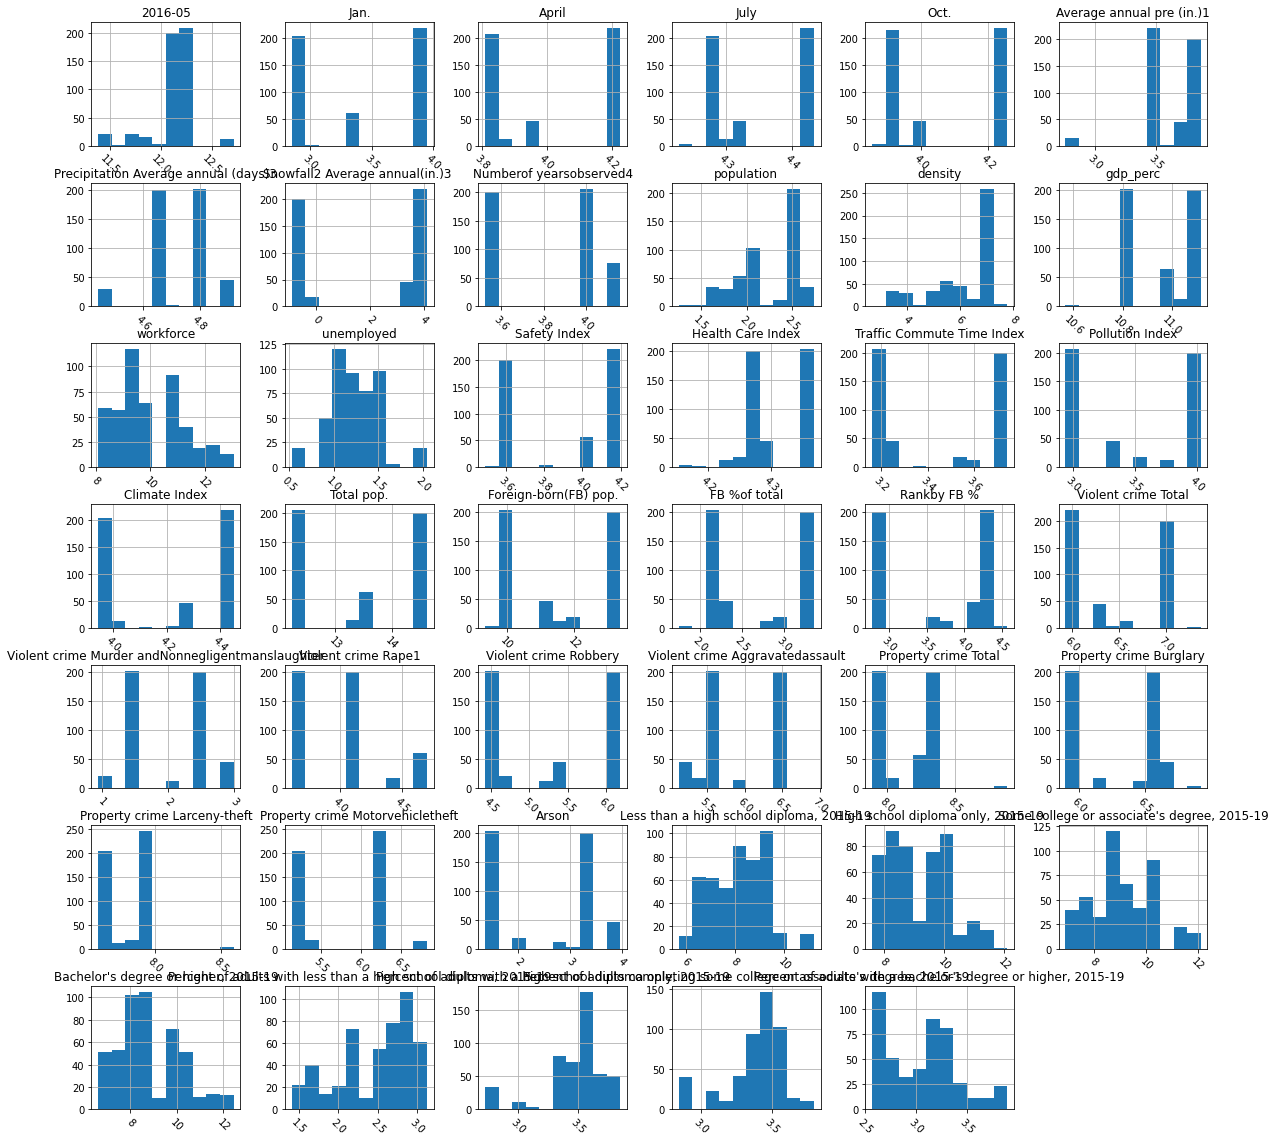

In [13]:
merged=pd.merge(housing,cities,left_on="RegionName",right_on="city")
merged=pd.merge(merged,climate,left_on="RegionName",right_on="City")
merged=pd.merge(merged,ppp,left_on="RegionName",right_on="metro")
merged=pd.merge(merged,unemployment,left_on="RegionName",right_on="county")
merged=pd.merge(merged,ql,left_on="RegionName",right_on="City")
merged=pd.merge(merged,inm,left_on="RegionName",right_on="City")
merged=pd.merge(merged,edu,left_on="RegionName",right_on="Area name")
merged=pd.merge(merged,crime,left_on="RegionName",right_on="City")


merged=merged[['2016-05',
               'Jan.',
       'April',
       'July',
       'Oct.',
       'Average annual pre (in.)1',
       'Precipitation Average annual (days)3',
       'Snowfall2 Average annual(in.)3 ',
       'Numberof yearsobserved4',
        'population',
       'density',
       'gdp_perc','workforce','unemployed',
       'Safety Index', 'Health Care Index',
       'Traffic Commute Time Index',
       'Pollution Index', 'Climate Index',
       'Total pop.', 'Foreign-born(FB) pop.', 'FB\xa0%of total',
       'Rankby FB\xa0%',  
        'Violent crime Total',
       'Violent crime Murder andNonnegligentmanslaughter',
       'Violent crime Rape1', 'Violent crime Robbery',
       'Violent crime Aggravatedassault',
       'Property crime Total', 'Property crime Burglary',
       'Property crime Larceny-theft',
       'Property crime Motorvehicletheft', 'Arson',
              'Less than a high school diploma, 2015-19',
       'High school diploma only, 2015-19',
       "Some college or associate's degree, 2015-19",
       "Bachelor's degree or higher, 2015-19",
       'Percent of adults with less than a high school diploma, 2015-19',
       'Percent of adults with a high school diploma only, 2015-19',
       "Percent of adults completing some college or associate's degree, 2015-19",
       "Percent of adults with a bachelor's degree or higher, 2015-19"
]]



for col in merged.columns.values:    
    merged[col]=np.log(merged[col].replace(',','', regex=True).astype(float))

merged['population']=np.log(merged['population'].iloc[:500])
merged=merged.dropna().reset_index(drop=True)

merged.hist(figsize=(20,20), xrot=-45)

In [14]:
len(merged)

482

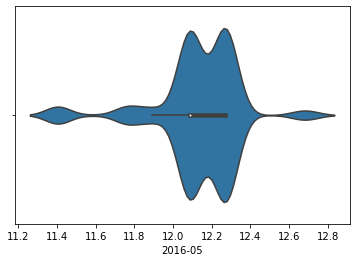

In [15]:
sns.violinplot(data=merged, x='2016-05')


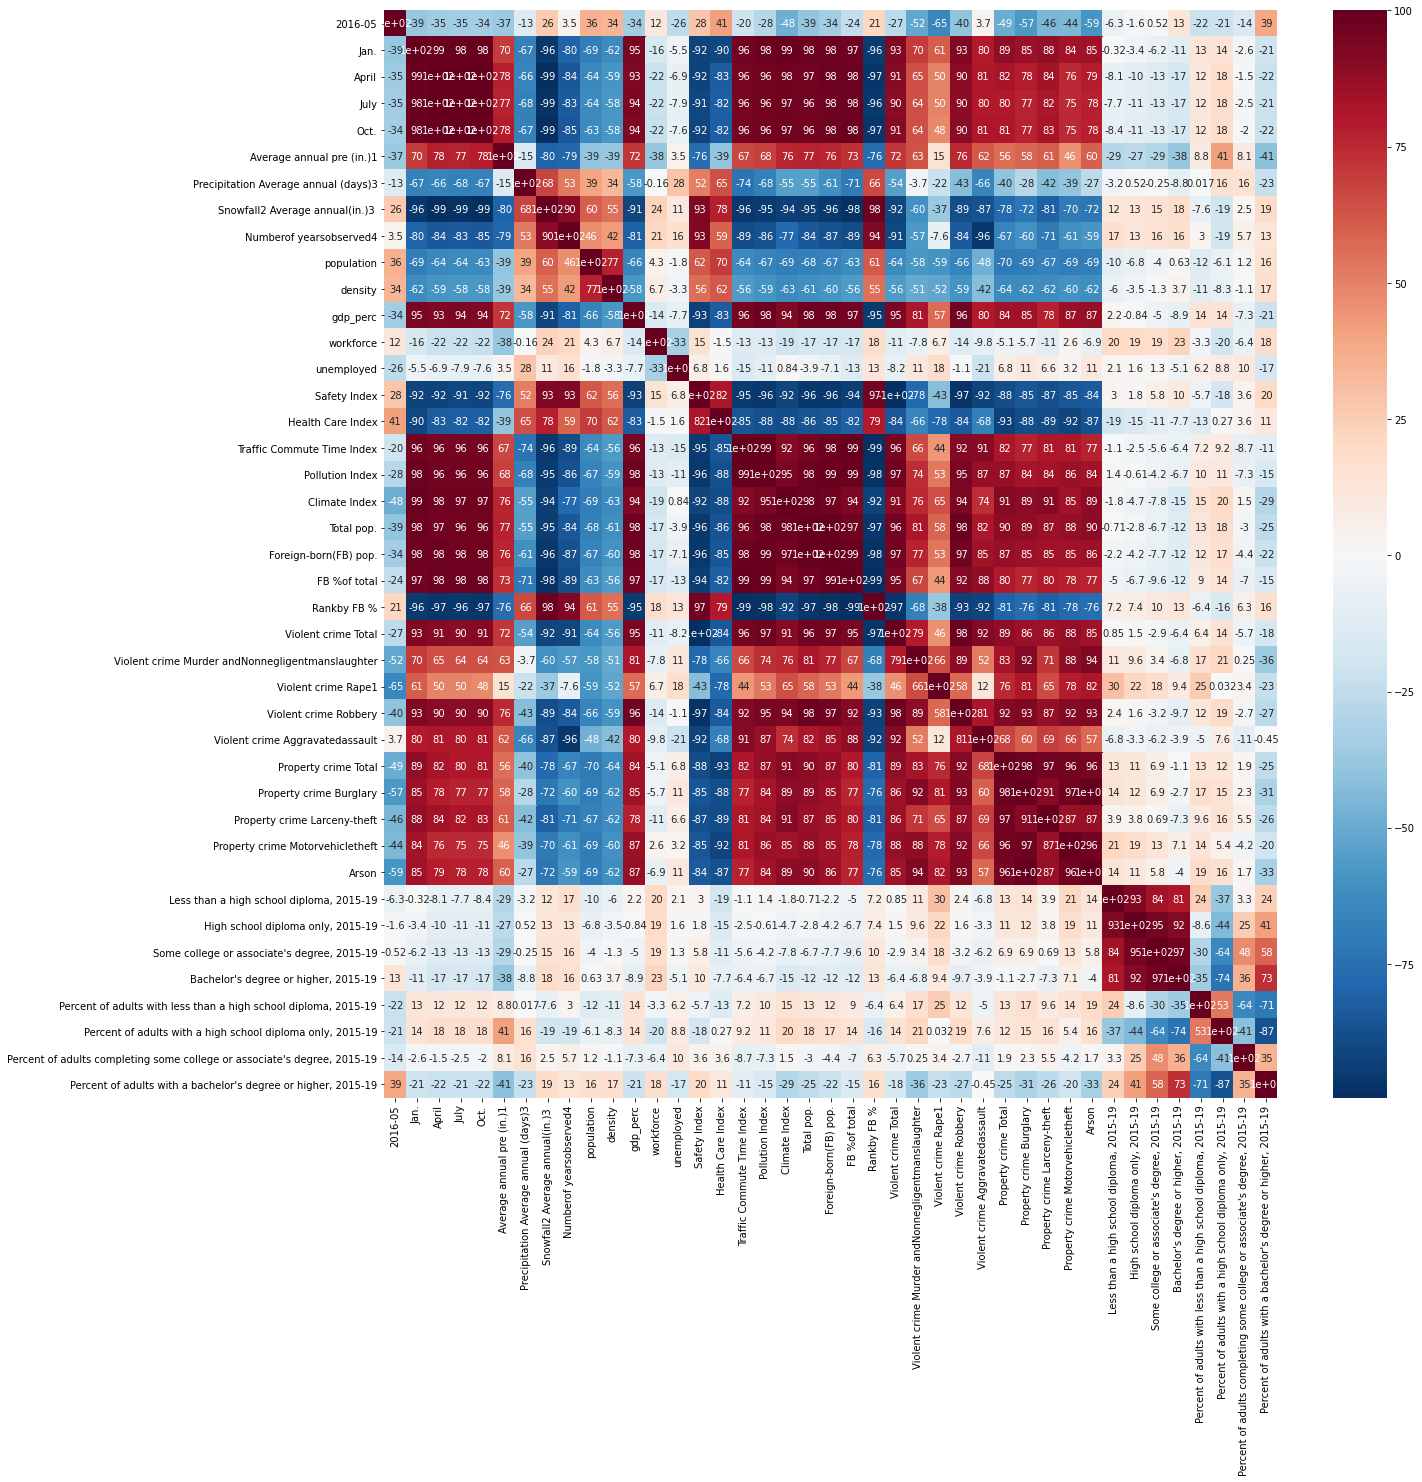

In [16]:
# Correlation heatmap

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(merged.corr()*100, 
           cmap='RdBu_r', 
           annot = True)         

Split data and more normalisation, cleaning

In [17]:
X=merged.drop(['2016-05'],axis=1)

scaler=StandardScaler()

X_train,X_test,y_train,y_test=train_test_split(X,merged['2016-05'],random_state=0)

conc=pd.concat([y_train,X_train],axis=1).dropna().reset_index(drop=True)
y_train=conc['2016-05']
X_train=conc.drop('2016-05',axis=1)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Build multiple models and compare the performance in the test set among the different hyperparameters with the best scores

In [18]:
clfs=[Lasso(random_state=123),Ridge(random_state=123),ElasticNet(random_state=123),RandomForestRegressor(random_state=123),GradientBoostingRegressor(random_state=123)]          
hyp=[[{'alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}],
[{'alpha' : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]}],
[{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10], 
    'l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]}],

[{'n_estimators' : [100, 200],
     'max_features' : ['auto', 'sqrt', 0.33],
     'min_samples_leaf' : [1, 3, 5, 10]}],
[{'n_estimators' : [100, 200],
      'learning_rate' : [0.05, 0.1, 0.2],
      'max_depth' : [1, 3, 5]}]]
      


fitted_models = {}
for i, clf  in enumerate(clfs):
    model = GridSearchCV(clf, 
                         hyp[i],  
                         cv=10, 
                         n_jobs=-1)
    
    model.fit(X_train, y_train)
    print(i) 
    print(model.best_score_)
    fitted_models[i] = model

0
0.575263841607998
1
0.5748680897339483
2
0.5757100913297699
3
0.5984455705976953
4
0.5989159700716995


In [19]:
for name, model in fitted_models.items():
   pred = model.predict(X_test)
   print(name)
   print(' — — — — ')
   print('R²:', r2_score(y_test, pred))
   print('MAE', mean_absolute_error(y_test, pred))

0
 — — — — 
R²: 0.6101371230082423
MAE 0.06373469972177728
1
 — — — — 
R²: 0.6619731725523756
MAE 0.05586160725739116
2
 — — — — 
R²: 0.6170140041294991
MAE 0.06266085843385578
3
 — — — — 
R²: 0.6508434812640363
MAE 0.05391232621698563
4
 — — — — 
R²: 0.6122073989126253
MAE 0.05778723546294248


1. Violent crime Aggravatedassault (0.131371)
2. Climate Index (0.110417)
3. Numberof yearsobserved4 (0.107883)
4. July (0.057834)
5. Property crime Larceny-theft (0.057599)
6. Total pop. (0.056039)
7. Property crime Burglary (0.049326)
8. Arson (0.042691)
9. Precipitation Average annual (days)3 (0.040900)
10. Oct. (0.037734)
11. Safety Index (0.029503)
12. Snowfall2 Average annual(in.)3  (0.025718)
13. April (0.025557)
14. Jan. (0.025312)
15. Property crime Total (0.022517)
16. Pollution Index (0.019954)
17. Traffic Commute Time Index (0.019665)
18. Average annual pre (in.)1 (0.018839)
19. Rankby FB % (0.017352)
20. Violent crime Total (0.016622)
21. Foreign-born(FB) pop. (0.015040)
22. FB %of total (0.013090)
23. Violent crime Rape1 (0.011716)
24. Violent crime Murder andNonnegligentmanslaughter (0.009794)
25. Property crime Motorvehicletheft (0.009277)
26. Health Care Index (0.006953)
27. Violent crime Robbery (0.003583)
28. density (0.003290)
29. Percent of adults with a high schoo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


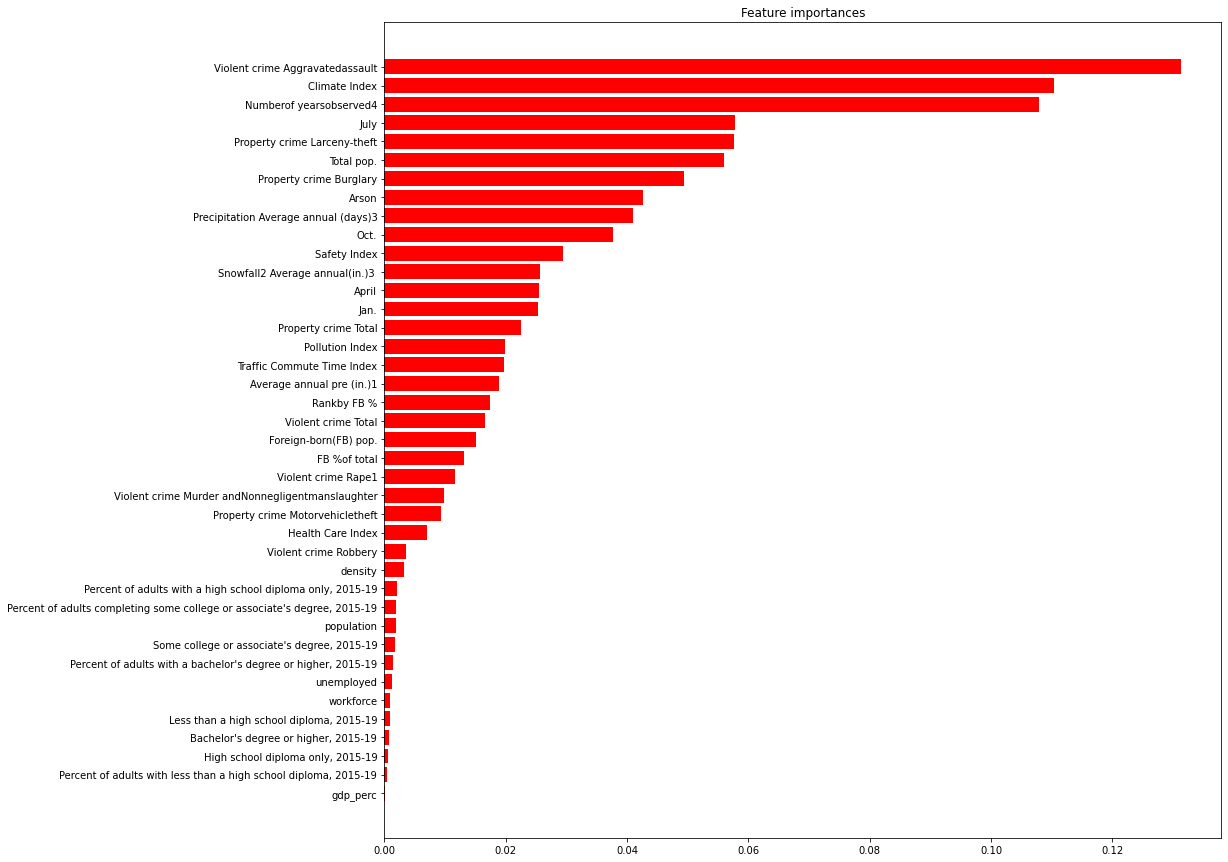

In [20]:
coef = fitted_models[3].best_estimator_.feature_importances_
ind = np.argsort(-coef)
for i in range(X_train.shape[1]):
    print("%d. %s (%f)" % (i + 1, X.columns[ind[i]], coef[ind[i]]))
x = range(X_train.shape[1])
y = coef[ind][:X_train.shape[1]]
plt.figure(figsize=(15,15))
plt.title("Feature importances")
ax = plt.subplot()
plt.barh(x, y, color='red')
ax.set_yticks(x)
ax.set_yticklabels(X.columns[ind])
plt.gca().invert_yaxis()





In [22]:
# Best hyperparameters for the Random Forest model
fitted_models[3].best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [23]:
len(X_train)

361

The models that generalize best in the test set are the Random Forest and the Gradient Boosting Descent. Among these models the one that minimizes error the most is the Random Forest.
Out of the most important features I would highlight: aggravated assault, climate index, weather in july, larceny theft and total population.